Time                     0
Inv 1 AC-Leistung (W)    0
anomaly_label            0
dtype: int64
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step 
Using full sequence error calculation
Best parameters for LogisticRegression: {'C': 1}
Best parameters for RandomForestClassifier: {'max_depth': None, 'n_estimators': 50}
Best parameters for XGBClassifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


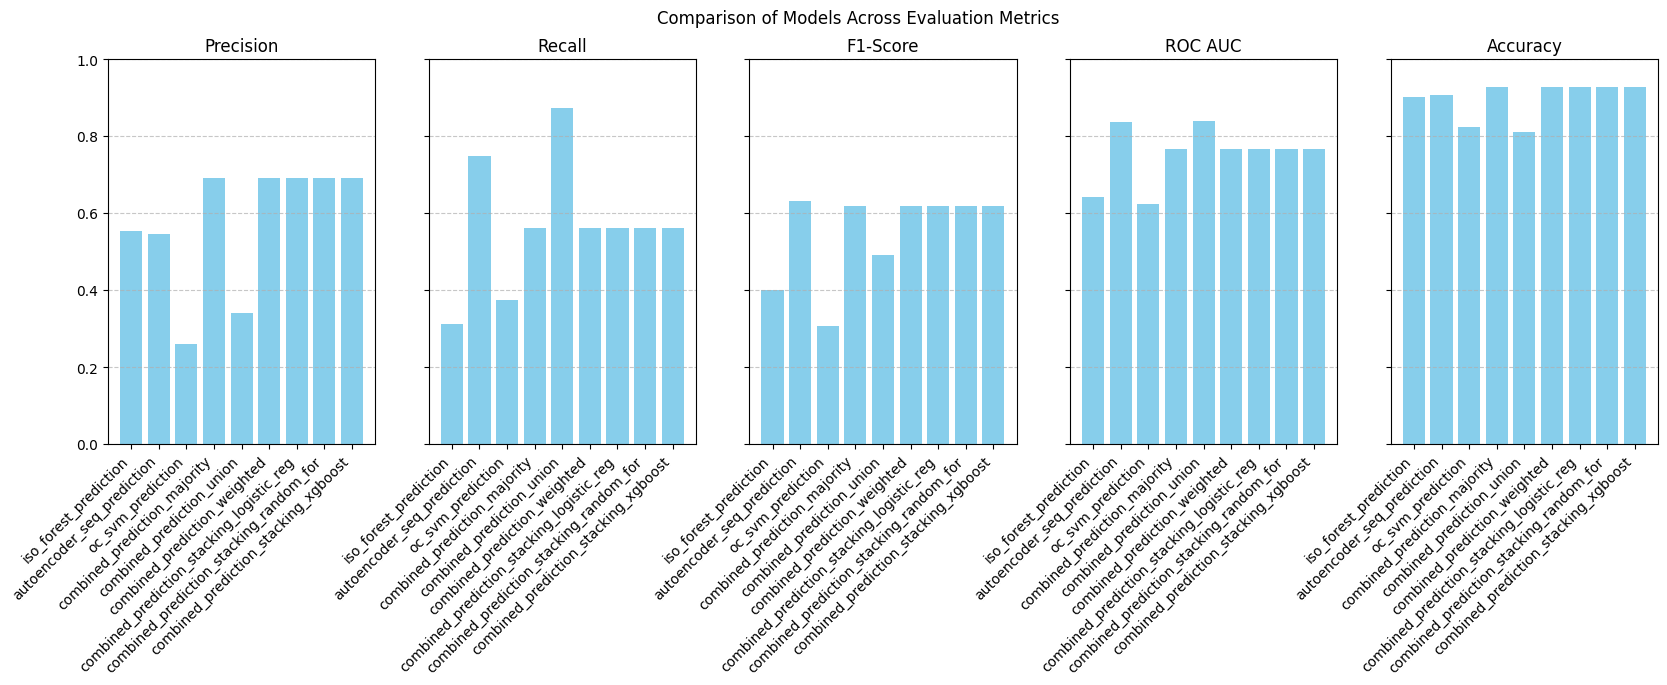

Standard Metrics:
                                           Precision  Recall  F1-Score  \
iso_forest_prediction                       0.555556  0.3125  0.400000   
autoencoder_seq_prediction                  0.545455  0.7500  0.631579   
oc_svm_prediction                           0.260870  0.3750  0.307692   
combined_prediction_majority                0.692308  0.5625  0.620690   
combined_prediction_union                   0.341463  0.8750  0.491228   
combined_prediction_weighted                0.692308  0.5625  0.620690   
combined_prediction_stacking_logistic_reg   0.692308  0.5625  0.620690   
combined_prediction_stacking_random_for     0.692308  0.5625  0.620690   
combined_prediction_stacking_xgboost        0.692308  0.5625  0.620690   

                                            ROC AUC  Accuracy  
iso_forest_prediction                      0.641651  0.901961  
autoencoder_seq_prediction                 0.838504  0.908497  
oc_svm_prediction                          0.6254

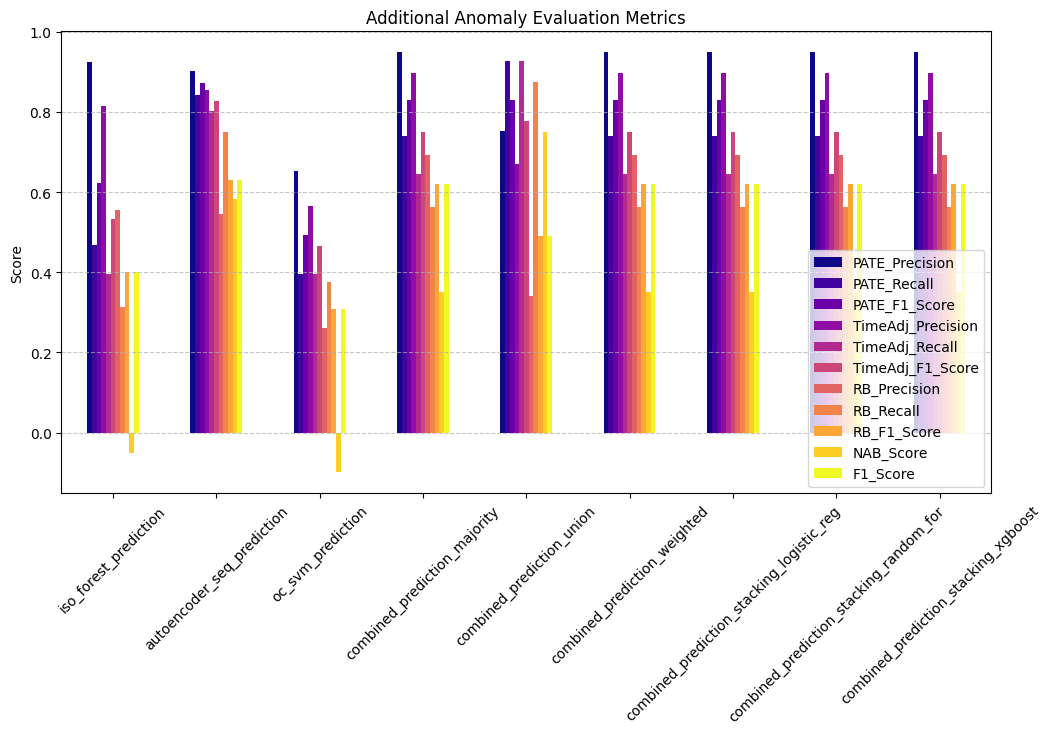

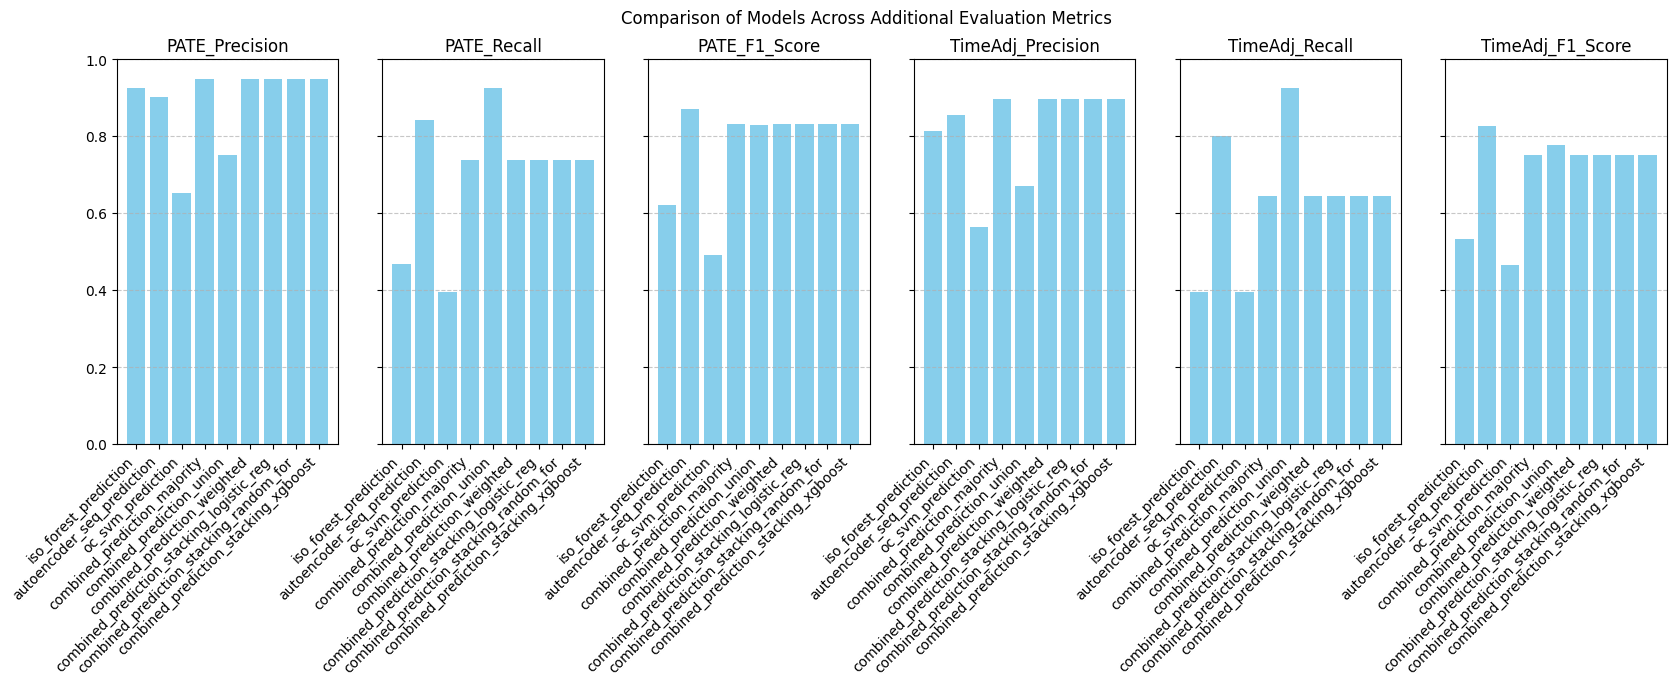

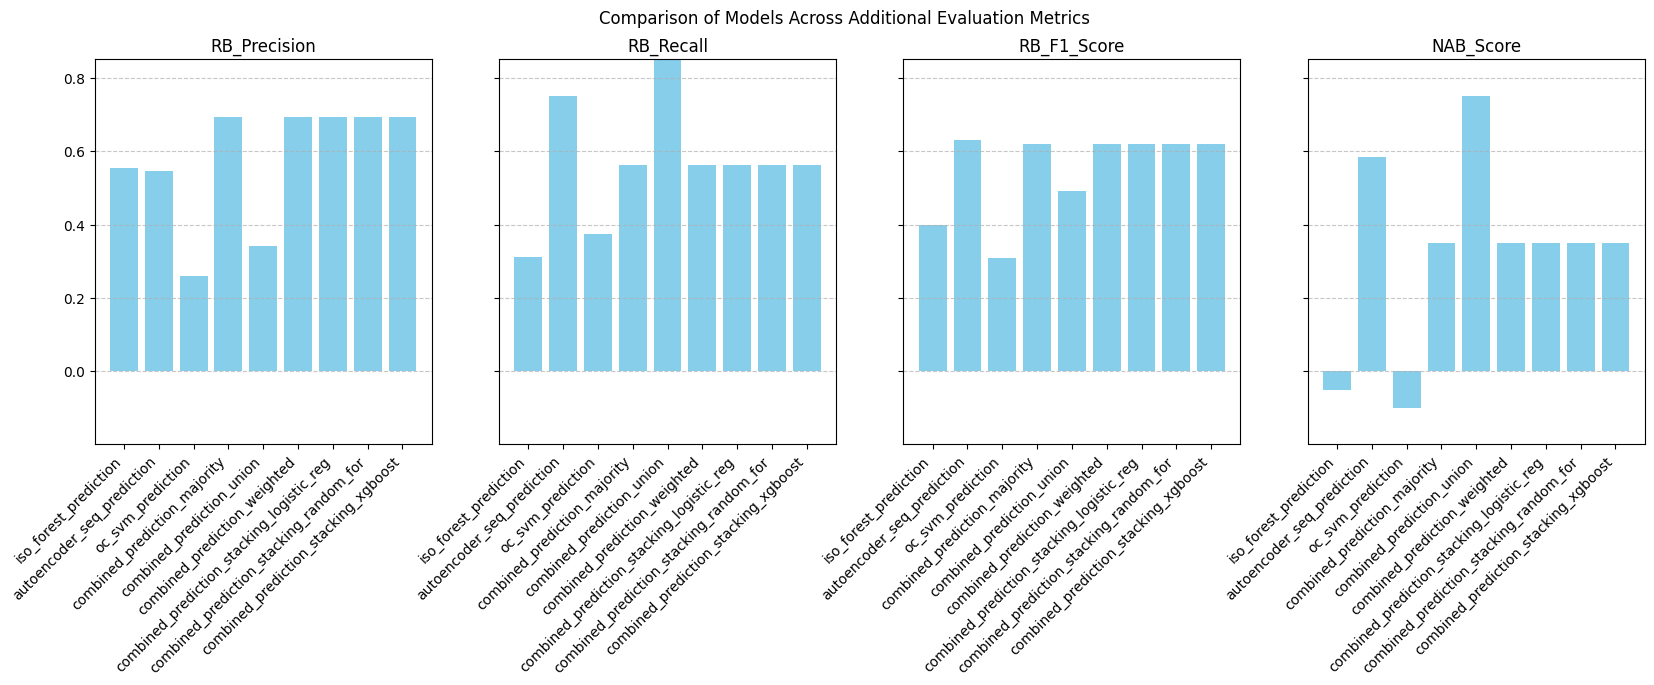


Additional Metrics:
Method: iso_forest_prediction
  PATE_Precision: 0.9259
  PATE_Recall: 0.4688
  PATE_F1_Score: 0.6224
  TimeAdj_Precision: 0.8148
  TimeAdj_Recall: 0.3958
  TimeAdj_F1_Score: 0.5328
  RB_Precision: 0.5556
  RB_Recall: 0.3125
  RB_F1_Score: 0.4000
  NAB_Score: -0.0500
  F1_Score: 0.4000
Method: autoencoder_seq_prediction
  PATE_Precision: 0.9015
  PATE_Recall: 0.8438
  PATE_F1_Score: 0.8717
  TimeAdj_Precision: 0.8561
  TimeAdj_Recall: 0.8021
  TimeAdj_F1_Score: 0.8282
  RB_Precision: 0.5455
  RB_Recall: 0.7500
  RB_F1_Score: 0.6316
  NAB_Score: 0.5833
  F1_Score: 0.6316
Method: oc_svm_prediction
  PATE_Precision: 0.6522
  PATE_Recall: 0.3958
  PATE_F1_Score: 0.4927
  TimeAdj_Precision: 0.5652
  TimeAdj_Recall: 0.3958
  TimeAdj_F1_Score: 0.4656
  RB_Precision: 0.2609
  RB_Recall: 0.3750
  RB_F1_Score: 0.3077
  NAB_Score: -0.0997
  F1_Score: 0.3077
Method: combined_prediction_majority
  PATE_Precision: 0.9487
  PATE_Recall: 0.7396
  PATE_F1_Score: 0.8312
  TimeAdj_Pre

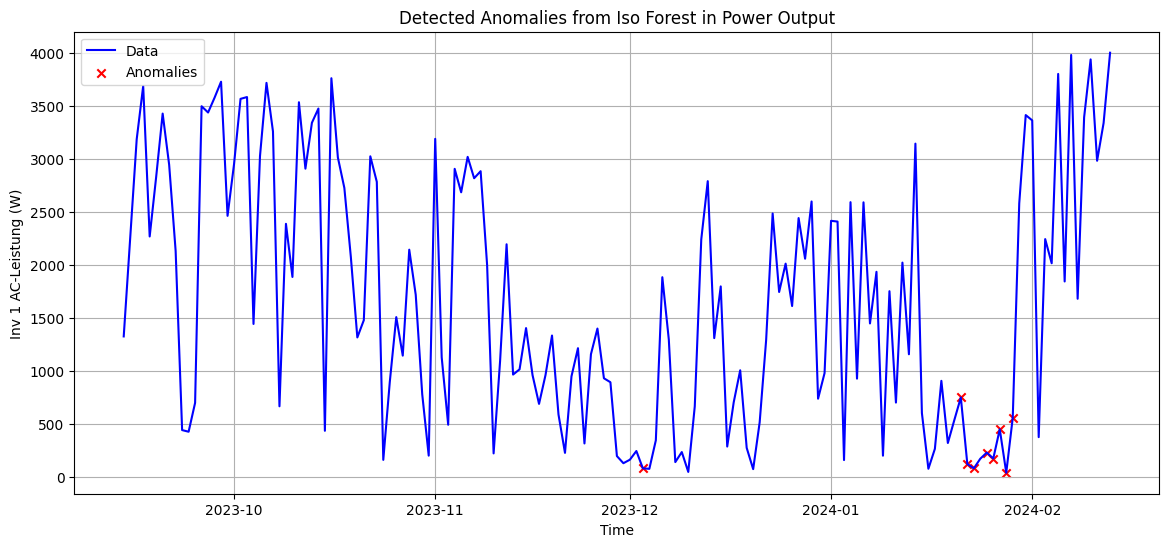

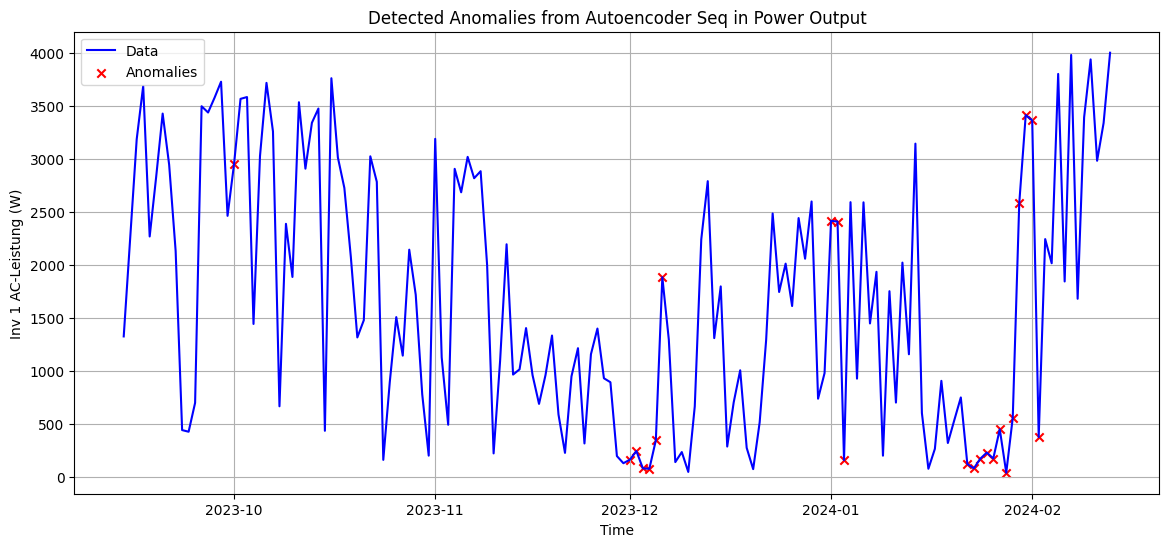

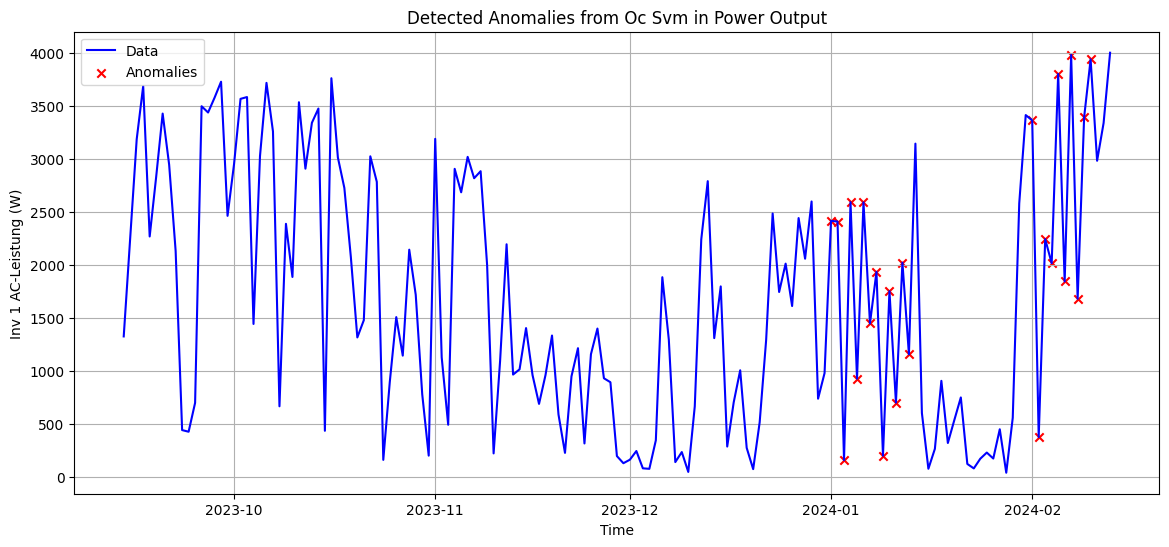

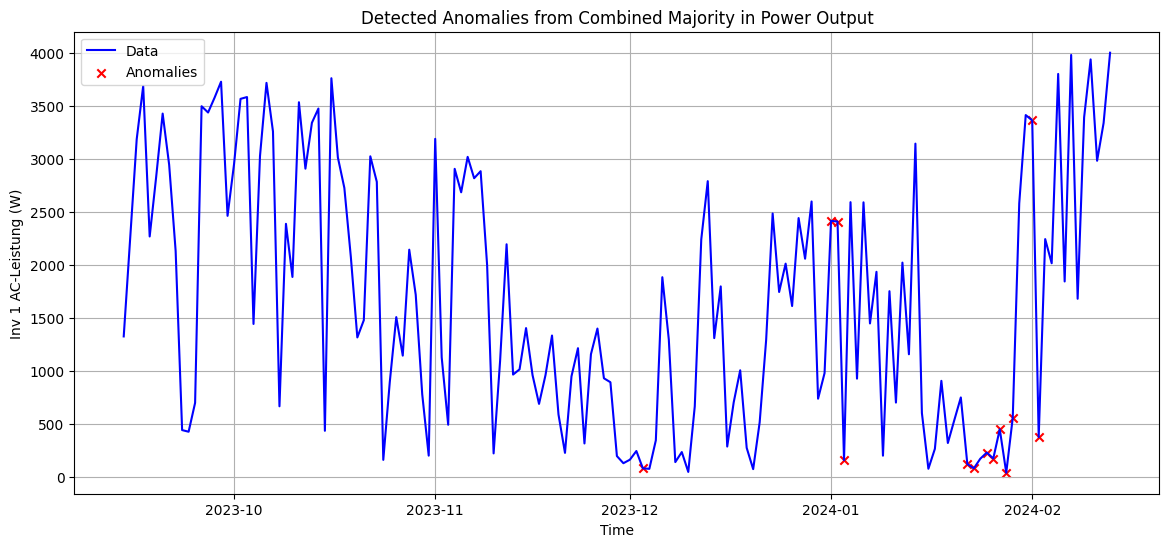

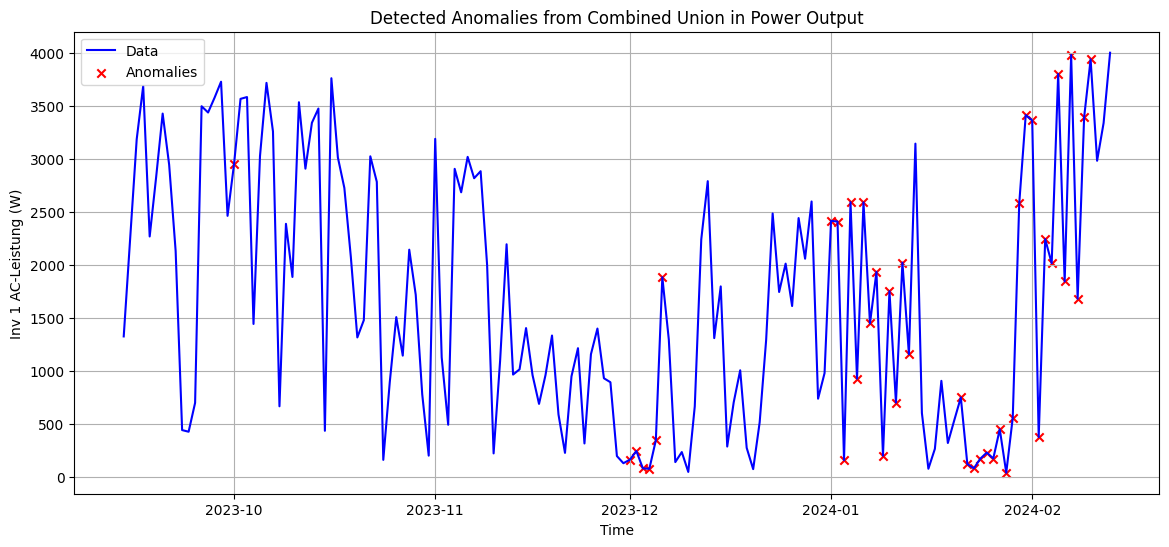

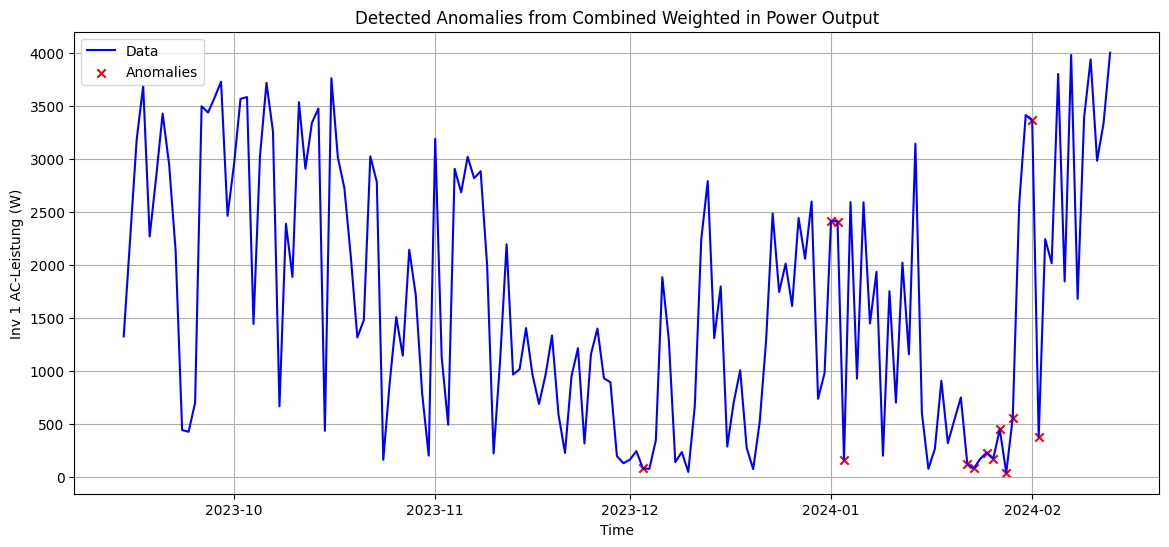

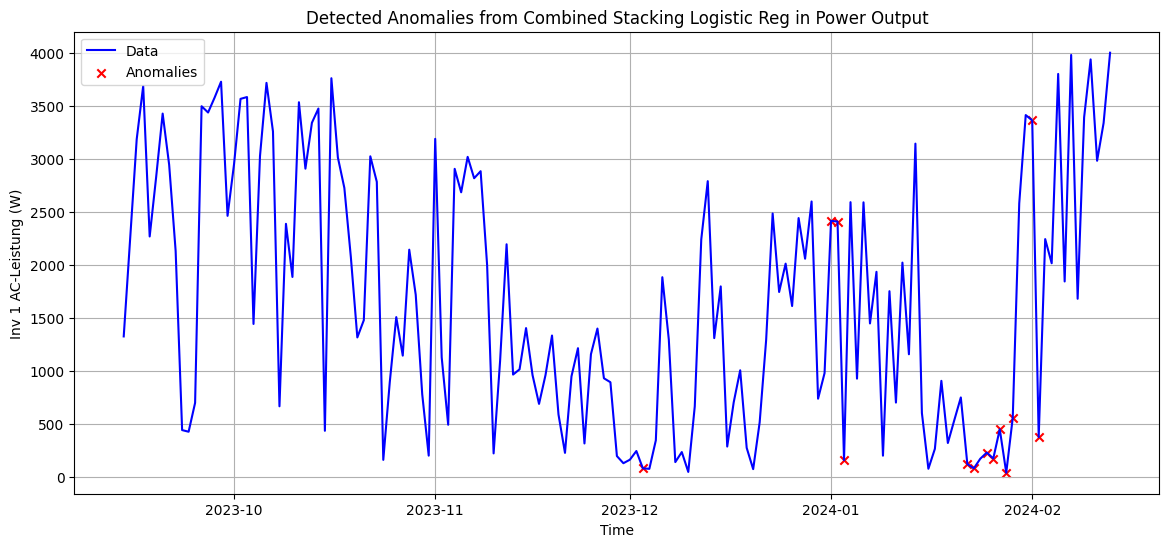

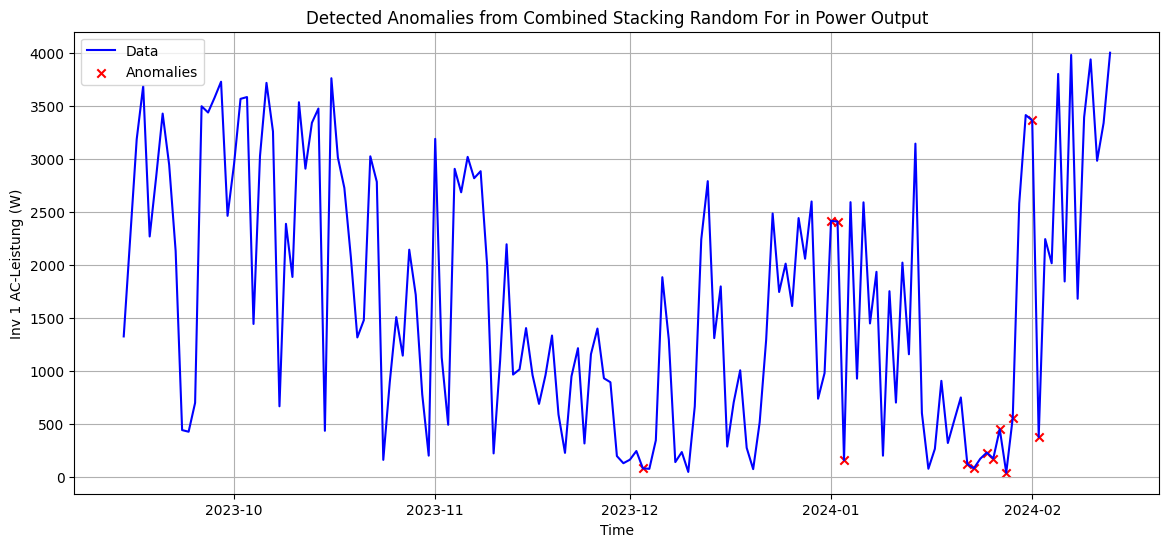

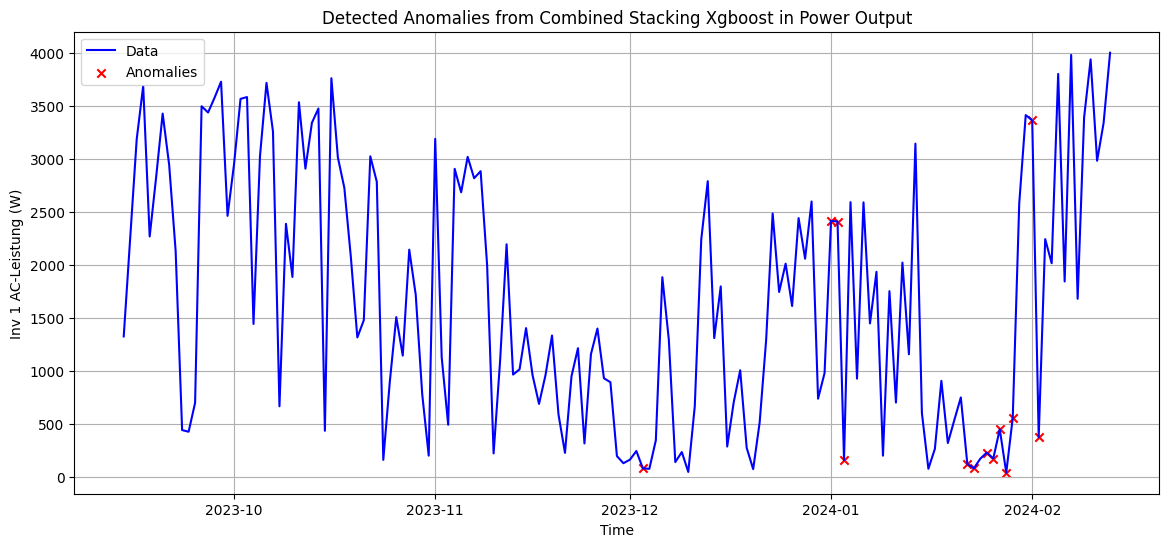

Performance report saved to reports/Anomaly_Detection_Performance_best_models_85.pdf


In [1]:
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from tensorflow.keras.models import load_model
import keras
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

from commons import create_sequences, load_data, add_advanced_time_features, add_lag_features, filter_and_save_data, scale_data, scale_selected_columns, preprocess_data_without_scaling, preprocess_data_with_scaling, plot_anomalies, add_moving_window_features
from commons import timesteps, data_file_path, time_column, target_column, train_data_split, train_data_path, eval_data_labeled_path, anomaly_trashold, window_size    # Variables which are shared across the application

############################################
# Define a dictionary for model-specific lags
############################################
model_lags = {
    'iso_forest': 4,
    'autoencoder_seq': 4,
    'oc_svm': 4  # for oc_svm the number of lags is irrelevant
}

############################################
# Build models_info dynamically using the lag values
############################################
models_info = {
    'iso_forest': {
        'path': f'USModels/isolation_forest_model_{model_lags["iso_forest"]}.pkl',
        'type': 'sklearn',
        'scaler': f'USModels/scaler_iso_forest_{model_lags["iso_forest"]}.pkl'
    },
    'autoencoder_seq': {
        'path': f'USModels/best_seq_autoencoder_model_{model_lags["autoencoder_seq"]}.keras',
        'type': 'keras',
        'scaler': f'USModels/scaler_ae_{model_lags["autoencoder_seq"]}.pkl'
    },
    'oc_svm': {
        'path': f'USModels/ocsvm_model_{model_lags["oc_svm"]}.pkl',
        'type': 'sklearn',
        'scaler': f'USModels/scaler_ocsvm_{model_lags["oc_svm"]}.pkl'
    }
}
##########################################
# Hyperparameter grids for each meta-model
############################################
meta_model_grids = {
    'logistic_reg': (
        LogisticRegression(max_iter=1000),
        {"C": [0.01, 0.1, 1, 10]}
    ),
    'random_for': (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [50, 100, 200], "max_depth": [None, 5, 10]}
    ),
    'xgboost': (
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        {"n_estimators": [50, 100, 200], "max_depth": [3, 5, 7], "learning_rate": [0.01, 0.1, 0.2]}
    )
}

###################################################
# Defining the weights for weighted average
####################################################
weights_dict = {
    'iso_forest': 0.4,
    'autoencoder_seq': 0.4,
    'oc_svm': 0.2
}

############################################
# Original functions (unchanged from your base code)
############################################

def plot_reconstruction_error(data, time_column, reconstruction_error, threshold, title="Reconstruction Error with Anomalies"):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data[time_column], reconstruction_error, label='Reconstruction Error', color='blue')
    anomalies = data[reconstruction_error > threshold]
    ax.scatter(anomalies[time_column], reconstruction_error[reconstruction_error > threshold], 
               color='red', label='Anomalies', marker='x')
    ax.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
    ax.set_title(title)
    ax.set_xlabel(time_column)
    ax.set_ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined_anomalies_only(data, time_column, value_column, predictions, title="Anomalies Detected"):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data[time_column], data[value_column], label='Data', color='blue')
    anomalies = data[predictions == -1]
    ax.scatter(anomalies[time_column], anomalies[value_column], color='red', label='Anomalies', marker='x')
    ax.set_title(title)
    ax.set_xlabel(time_column)
    ax.set_ylabel(value_column)
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_combined_anomalies(data, time_column, value_column, ensemble_type, title=None):
    data[time_column] = pd.to_datetime(data[time_column])
    if title is None:
        title = f"Anomalies Detected by Ensemble with {ensemble_type}"
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(data[time_column], data[value_column], label='Original Data', color='blue')
    colors = ['orange', 'red', 'green', 'purple', 'cyan', 'magenta']
    markers = ['x', 'o', '^', 's', 'd', '*']
    prediction_columns = [col for col in data.columns if col.endswith('_prediction')]
    for idx, pred_col in enumerate(prediction_columns):
        anomalies = data[data[pred_col] == -1]
        model_label = pred_col.replace('_prediction', '').replace('_', ' ').title() + ' Anomalies'
        ax.scatter(
            anomalies[time_column], anomalies[value_column],
            color=colors[idx % len(colors)],
            marker=markers[idx % len(markers)],
            label=model_label
        )
    ax.set_title(title)
    ax.set_xlabel(time_column)
    ax.set_ylabel(value_column)
    plt.legend()
    plt.grid(True)
    plt.show()

def load_models(models_info):
    models = {}
    scalers = {}
    for model_name, info in models_info.items():
        model_path = info['path']
        model_type = info['type']
        scaler_path = info.get('scaler')
        if model_type == 'sklearn':
            models[model_name] = joblib.load(model_path)
        elif model_type == 'keras':
            models[model_name] = load_model(model_path)
        else:
            raise ValueError(f"Unsupported model type: {model_type}")
        if scaler_path:
            scalers[model_name] = joblib.load(scaler_path)
        else:
            scalers[model_name] = None
    return models, scalers

def scale_selected_columns(data, feature_columns_to_scale, scaler):
    data_scaled = data.copy()
    data_scaled[feature_columns_to_scale] = scaler.transform(data[feature_columns_to_scale])
    return data_scaled

def make_prediction(model, model_name, preprocessed_data, data, ocsvm_threshold=anomaly_trashold):
    prediction_col = f"{model_name}_prediction"
    if isinstance(model, (IsolationForest, OneClassSVM)):
        if isinstance(model, OneClassSVM):
            anomaly_scores = -model.decision_function(preprocessed_data)
            threshold = np.percentile(anomaly_scores, ocsvm_threshold)
            predictions = np.where(anomaly_scores > threshold, -1, 1)
        else:
            predictions = model.predict(preprocessed_data)
    elif isinstance(model, keras.Model):
        if "autoencoder_deep" in model_name.lower():
            reconstructed_data = model.predict(preprocessed_data)
            reconstruction_error = np.mean(np.abs(preprocessed_data - reconstructed_data), axis=1)
            threshold = np.percentile(reconstruction_error, anomaly_trashold)
            predictions = np.where(reconstruction_error > threshold, -1, 1)
        elif "autoencoder_seq" in model_name.lower():
            timesteps = model_lags[model_name]
            if preprocessed_data.shape[0] >= timesteps:
                preprocessed_data_seq = create_sequences(preprocessed_data, timesteps)
            else:
                raise ValueError("Not enough samples to create the required sliding windows.")
            reconstructed_data = model.predict(preprocessed_data_seq)
            if reconstructed_data.shape != preprocessed_data_seq.shape:
                print("Using sequence-to-one error calculation (comparing last time step)")
                reconstruction_error = np.mean(np.abs(preprocessed_data_seq[:, -1, :] - reconstructed_data), axis=1)
            else:
                print("Using full sequence error calculation")
                reconstruction_error = np.mean(np.abs(preprocessed_data_seq - reconstructed_data), axis=(1, 2))
            threshold = np.percentile(reconstruction_error, anomaly_trashold)
            predictions_seq = np.where(reconstruction_error > threshold, -1, 1)
            predictions = np.ones(preprocessed_data.shape[0], dtype=int)
            predictions[timesteps - 1:] = predictions_seq
        else:
            raise ValueError(f"Unsupported keras model type: {model_name}")
    else:
        raise ValueError(f"Unsupported model instance: {model}")
    data[prediction_col] = predictions
    return data

def weighted_average_ensemble(predictions_matrix, prediction_columns, weights_dict):
    """
    Computes a weighted average ensemble prediction.
    """
    model_names = [col.replace('_prediction', '') for col in prediction_columns]
    weights = np.array([weights_dict.get(model, 1) for model in model_names])
    weights = weights / np.sum(weights)
    weighted_sum = np.dot(predictions_matrix, weights)
    final_predictions = np.where(weighted_sum < 0, -1, 1)
    return final_predictions

# Define meta-models with hyperparameter tuning
def stacking_ensemble_train(base_predictions, true_labels, meta_model, param_grid):
    y_meta = np.where(true_labels == -1, 1, 0)
    grid_search = GridSearchCV(
        meta_model,
        param_grid,
        scoring='f1_weighted',
        cv=5,
        n_jobs=-1
    )
    grid_search.fit(base_predictions, y_meta)
    print(f"Best parameters for {type(meta_model).__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

def stacking_ensemble_predict(base_predictions, meta_model, threshold=0.5):
    anomaly_class_index = list(meta_model.classes_).index(1)
    anomaly_probs = meta_model.predict_proba(base_predictions)[:, anomaly_class_index]
    final_predictions = np.where(anomaly_probs >= threshold, -1, 1)
    return final_predictions

############################################
# New Evaluation Metrics
############################################

def compute_pate(true_labels, predictions, tolerance=5):
    """
    Proximity-Aware Time-series Anomaly Evaluation (PATE).
    For each predicted anomaly, a weight is given based on its distance
    to the nearest true anomaly (and vice versa) within a tolerance window.
    """
    true_indices = np.where(true_labels == -1)[0]
    pred_indices = np.where(predictions == -1)[0]
    # Precision computation
    if len(pred_indices) == 0:
        pate_precision = 0.0
    else:
        prec_sum = 0.0
        for idx in pred_indices:
            if len(true_indices) > 0:
                distance = np.min(np.abs(true_indices - idx))
                weight = 1 - (distance / (tolerance + 1)) if distance <= tolerance else 0
            else:
                weight = 0
            prec_sum += weight
        pate_precision = prec_sum / len(pred_indices)
    # Recall computation
    if len(true_indices) == 0:
        pate_recall = 0.0
    else:
        rec_sum = 0.0
        for idx in true_indices:
            if len(pred_indices) > 0:
                distance = np.min(np.abs(pred_indices - idx))
                weight = 1 - (distance / (tolerance + 1)) if distance <= tolerance else 0
            else:
                weight = 0
            rec_sum += weight
        pate_recall = rec_sum / len(true_indices)
    return pate_precision, pate_recall

def compute_time_adjusted_precision_recall(true_labels, predictions, max_delay=5):
    """
    Time-Adjusted Precision/Recall: For each true anomaly, if a detection is delayed,
    its credit decays linearly with delay (up to max_delay).
    """
    true_indices = np.where(true_labels == -1)[0]
    pred_indices = np.where(predictions == -1)[0]
    recall_weights = []
    for t in true_indices:
        future_preds = pred_indices[pred_indices >= t]
        if len(future_preds) > 0:
            delay = future_preds[0] - t
            weight = 1 - (delay / (max_delay + 1)) if delay <= max_delay else 0
        else:
            weight = 0
        recall_weights.append(weight)
    time_adj_recall = np.mean(recall_weights) if recall_weights else 0

    precision_weights = []
    for p in pred_indices:
        past_trues = true_indices[true_indices <= p]
        if len(past_trues) > 0:
            delay = p - past_trues[-1]
            weight = 1 - (delay / (max_delay + 1)) if delay <= max_delay else 0
        else:
            weight = 0
        precision_weights.append(weight)
    time_adj_precision = np.mean(precision_weights) if precision_weights else 0

    return time_adj_precision, time_adj_recall

def extract_anomaly_ranges(labels):
    """
    Extract contiguous ranges where anomalies occur.
    Returns a list of (start_index, end_index) tuples.
    """
    ranges = []
    in_range = False
    start = None
    for i, label in enumerate(labels):
        if label == -1 and not in_range:
            in_range = True
            start = i
        elif label != -1 and in_range:
            end = i - 1
            ranges.append((start, end))
            in_range = False
    if in_range:
        ranges.append((start, len(labels) - 1))
    return ranges

def compute_range_based_precision_recall(true_labels, predictions):
    """
    Range-Based Precision and Recall: Compute the overlap (in terms of duration)
    between predicted anomaly ranges and true anomaly ranges.
    """
    true_ranges = extract_anomaly_ranges(true_labels)
    pred_ranges = extract_anomaly_ranges(predictions)
    total_true_duration = sum(end - start + 1 for start, end in true_ranges)
    total_pred_duration = sum(end - start + 1 for start, end in pred_ranges)
    total_overlap = 0
    for p_start, p_end in pred_ranges:
        for t_start, t_end in true_ranges:
            overlap = max(0, min(p_end, t_end) - max(p_start, t_start) + 1)
            total_overlap += overlap
    rb_precision = total_overlap / total_pred_duration if total_pred_duration > 0 else 0
    rb_recall = total_overlap / total_true_duration if total_true_duration > 0 else 0
    return rb_precision, rb_recall

def compute_NAB_score(true_labels, predictions, pre_window=5, post_window=5, false_positive_penalty=0.11):
    """
    Simplified Numenta Anomaly Benchmark (NAB) Score.
    For each true anomaly range, a detection within an extended window scores higher if detected early.
    False positives outside any true anomaly window incur a penalty.
    """
    true_ranges = extract_anomaly_ranges(true_labels)
    pred_indices = np.where(predictions == -1)[0]
    score = 0.0
    for start, end in true_ranges:
        window_start = max(0, start - pre_window)
        window_end = end + post_window
        window_preds = [p for p in pred_indices if window_start <= p <= window_end]
        if window_preds:
            detection_time = min(window_preds)
            delay = detection_time - start if detection_time >= start else 0
            window_length = (post_window + 1)
            detection_score = max(0, 1 - (delay / window_length))
        else:
            detection_score = -1  # penalty for missing detection
        score += detection_score
    associated_preds = []
    for start, end in true_ranges:
        window_start = max(0, start - pre_window)
        window_end = end + post_window
        for p in pred_indices:
            if window_start <= p <= window_end:
                associated_preds.append(p)
    associated_preds = set(associated_preds)
    false_positives = len(pred_indices) - len(associated_preds)
    fp_penalty = false_positives * false_positive_penalty
    nab_score = score - fp_penalty
    nab_score_normalized = nab_score / len(true_ranges) if true_ranges else 0
    return nab_score_normalized

############################################
# Create performance report PDF (updated to include additional metrics)
############################################

def create_performance_report_pdf(labeled_data, prediction_methods, output_filename="performance_report.pdf"):
    true_labels = labeled_data["anomaly_label"].values
    with PdfPages(output_filename) as pdf:
        for method in prediction_methods:
            if method not in labeled_data.columns:
                print(f"Prediction method column '{method}' not found in the DataFrame.")
                continue
            y_pred = labeled_data[method].values
            precision = precision_score(true_labels, y_pred, pos_label=-1)
            recall = recall_score(true_labels, y_pred, pos_label=-1)
            f1 = f1_score(true_labels, y_pred, pos_label=-1)
            roc_auc = roc_auc_score((true_labels == -1).astype(int), (y_pred == -1).astype(int))
            accuracy = accuracy_score(true_labels, y_pred)
            cm = confusion_matrix(true_labels, y_pred, labels=[-1, 1])
            fpr, tpr, _ = roc_curve((true_labels == -1).astype(int), (y_pred == -1).astype(int))
            roc_auc_val = auc(fpr, tpr)
            
            # Compute additional metrics
            pate_prec, pate_rec = compute_pate(true_labels, y_pred, tolerance=5)
            ta_prec, ta_rec = compute_time_adjusted_precision_recall(true_labels, y_pred, max_delay=5)
            rb_prec, rb_rec = compute_range_based_precision_recall(true_labels, y_pred)
            nab_score = compute_NAB_score(true_labels, y_pred, pre_window=5, post_window=5, false_positive_penalty=0.11)
            
            dynamic_title = f"Performance Report for {method}"
            anomaly_vis_title = dynamic_title + " - Anomaly Visualization"
            fig = plt.figure(figsize=(12, 20))
            ax_text = fig.add_subplot(6, 1, 1)
            ax_text.axis('off')
            text_str = (
                f"{dynamic_title}\n\n"
                f"Precision: {precision:.4f}\n"
                f"Recall: {recall:.4f}\n"
                f"F1-Score: {f1:.4f}\n"
                f"ROC AUC: {roc_auc:.4f}\n"
                f"Accuracy: {accuracy:.4f}\n"
                f"\nPATE Precision: {pate_prec:.4f}\n"
                f"PATE Recall: {pate_rec:.4f}\n"
                f"Time-Adjusted Precision: {ta_prec:.4f}\n"
                f"Time-Adjusted Recall: {ta_rec:.4f}\n"
                f"Range-Based Precision: {rb_prec:.4f}\n"
                f"Range-Based Recall: {rb_rec:.4f}\n"
                f"NAB Score: {nab_score:.4f}\n"
            )
            ax_text.text(0.05, 0.5, text_str, fontsize=12, verticalalignment='center')
            ax_roc = fig.add_subplot(6, 1, 2)
            ax_roc.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_val:.2f})')
            ax_roc.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
            ax_roc.set_xlabel("False Positive Rate")
            ax_roc.set_ylabel("True Positive Rate")
            ax_roc.set_title("ROC Curve")
            ax_roc.legend(loc="lower right")
            ax_roc.grid(True)
            ax_cm = fig.add_subplot(6, 1, 3)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                        xticklabels=["Anomaly (-1)", "Normal (1)"],
                        yticklabels=["Anomaly (-1)", "Normal (1)"],
                        ax=ax_cm)
            ax_cm.set_xlabel("Predicted Label")
            ax_cm.set_ylabel("True Label")
            ax_cm.set_title("Confusion Matrix")
            ax_anom = fig.add_subplot(6, 1, 4)
            ax_anom.plot(labeled_data[time_column], labeled_data[target_column], label='Data', color='blue')
            anomalies = labeled_data[labeled_data[method] == -1]
            ax_anom.scatter(anomalies[time_column], anomalies[target_column], 
                            color='red', label='Anomalies', marker='x')
            ax_anom.set_title(anomaly_vis_title)
            ax_anom.set_xlabel(time_column)
            ax_anom.set_ylabel(target_column)
            ax_anom.legend()
            ax_anom.grid(True)
            ax_bar = fig.add_subplot(6, 1, 5)
            bar_metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
            bar_values = [precision, recall, f1, roc_auc, accuracy]
            ax_bar.bar(bar_metrics, bar_values, color=['blue', 'green', 'red', 'purple', 'orange'])
            ax_bar.set_ylim(0, 1)
            ax_bar.set_xlabel("Evaluation Metrics")
            ax_bar.set_ylabel("Score")
            ax_bar.set_title("Anomaly Detection Model Evaluation Metrics")
            ax_bar.set_xticklabels(bar_metrics, rotation=45)
            ax_bar.grid(axis="y", linestyle="--", alpha=0.7)
            # Additional metrics bar plot
            additional_metrics = ["PATE Precision", "PATE Recall", "TimeAdj Precision", "TimeAdj Recall", "RB Precision", "RB Recall", "NAB Score"]
            additional_values = [pate_prec, pate_rec, ta_prec, ta_rec, rb_prec, rb_rec, nab_score]
            ax_bar2 = fig.add_subplot(6, 1, 6)
            ax_bar2.bar(additional_metrics, additional_values, color='teal')
            ax_bar2.set_ylim(min(-1, min(additional_values)) , 1)
            ax_bar2.set_xlabel("Additional Evaluation Metrics")
            ax_bar2.set_ylabel("Score")
            ax_bar2.set_title("Additional Anomaly Evaluation Metrics")
            ax_bar2.set_xticklabels(additional_metrics, rotation=45)
            ax_bar2.grid(axis="y", linestyle="--", alpha=0.7)
            fig.suptitle(dynamic_title, fontsize=16)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            pdf.savefig(fig)
            plt.close(fig)
        print(f"Performance report saved to {output_filename}")



def plot_additional_metrics_subplots(additional_metrics, new_metrics, figsize=(20, 5)):
    """
    Plots additional evaluation metrics in subplots with the same formatting as the original metrics.
    
    Parameters:
      - additional_metrics: dict
            A dictionary with model names as keys and a sub-dictionary of additional metric values.
            For example:
            {
                "iso_forest_prediction": {
                    "PATE_Precision": 0.8,
                    "PATE_Recall": 0.75,
                    "TimeAdj_Precision": 0.85,
                    "TimeAdj_Recall": 0.80,
                    "RB_Precision": 0.90,
                    "RB_Recall": 0.88,
                    "NAB_Score": 0.50
                },
                ...
            }
      - new_metrics: list of str
            The list of metric names (keys) to plot.
      - figsize: tuple, the figure size (width, height).
    """


    # Convert the additional_metrics dictionary into a DataFrame.
    additional_df = pd.DataFrame.from_dict(additional_metrics, orient='index')

    # Create subplots for each additional metric, using a shared y-axis as in the original.
    fig, axes = plt.subplots(1, len(new_metrics), figsize=figsize, sharey=True)
    
    for i, metric in enumerate(new_metrics):
        axes[i].bar(additional_df.index, additional_df[metric], color='skyblue')
        axes[i].set_title(metric)
        axes[i].set_xticklabels(additional_df.index, rotation=45, ha='right')
        
        # For metrics other than NAB_Score, we assume values are between 0 and 1.
        if metric == "NAB_Score":
            # If NAB_Score values extend outside [0, 1], set dynamic limits.
            if additional_df[metric].max() > 1 or additional_df[metric].min() < 0:
                y_min = additional_df[metric].min() - 0.1
                y_max = additional_df[metric].max() + 0.1
                axes[i].set_ylim(y_min, y_max)
            else:
                axes[i].set_ylim(0, 1)
        else:
            axes[i].set_ylim(0, 1)
        axes[i].grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.suptitle("Comparison of Models Across Additional Evaluation Metrics")
    #plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()



############################################
# Data Loading and Preprocessing
############################################

labeled_data = load_data(eval_data_labeled_path)
labeled_data.head()

nan_counts = labeled_data.isna().sum()
print(nan_counts)
labeled_data.interpolate(method='linear', inplace=True)
labeled_data.ffill(inplace=True)
labeled_data = add_advanced_time_features(labeled_data, time_column)

############################################
# Create separate labeled_data for each model using its lag configuration
############################################

labeled_data_dict = {}
for model_name, lag in model_lags.items():
    temp_df = labeled_data.copy()
    temp_df = add_lag_features(temp_df, target_column=target_column, n_lags=lag)
    temp_df = add_moving_window_features(temp_df, target_column, window_size=window_size)
    labeled_data_dict[model_name] = temp_df

############################################
# Load the models and scalers dynamically
############################################

models, scalers = load_models(models_info)

############################################
# Prepare data for each model:
############################################

exclude_columns = ['hour','hour_cos', 'hour_sin', 'day', 'day_of_week', 'week_of_year', 'month', 'is_weekend', 'anomaly_label', time_column]

preprocessed_data = {}
for model_name, df in labeled_data_dict.items():
    feature_columns = df.columns.tolist()
    feature_columns_to_scale = [col for col in feature_columns if col not in exclude_columns]
    scaled_df = scale_selected_columns(df, feature_columns_to_scale, scalers[model_name])
    numeric_df = scaled_df.drop(columns=[time_column, 'anomaly_label'])
    preprocessed_data[model_name] = numeric_df
    labeled_data_dict[model_name] = scaled_df

############################################
# Make predictions for each model
############################################

for model_name, model in models.items():
    df_numeric = preprocessed_data[model_name]
    labeled_data_dict[model_name] = make_prediction(model, model_name, df_numeric, labeled_data_dict[model_name])

############################################
# Merge predictions into the main labeled_data using 'Time' as key
############################################

for model_name in models.keys():
    prediction_col = f"{model_name}_prediction"
    labeled_data = labeled_data.merge(
        labeled_data_dict[model_name][[time_column, prediction_col]],
        on=time_column,
        how='left'
    )

prediction_columns = [col for col in labeled_data.columns if col.endswith('_prediction')]
labeled_data[prediction_columns] = labeled_data[prediction_columns].fillna(1)

############################################
# Combine predictions for ensemble methods
############################################

predictions_matrix = np.column_stack([labeled_data[col].values for col in prediction_columns])
labeled_data["combined_prediction_majority"] = np.where(np.sum(predictions_matrix, axis=1) < 0, -1, 1)
labeled_data["combined_prediction_weighted"] = weighted_average_ensemble(predictions_matrix, prediction_columns, weights_dict)
labeled_data["combined_prediction_union"] = np.where(np.any(predictions_matrix == -1, axis=1), -1, 1)

# Train and predict with tuned meta-models
for model_name, (meta_model, param_grid) in meta_model_grids.items():
    trained_meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model, param_grid)
    labeled_data[f"combined_prediction_stacking_{model_name}"] = stacking_ensemble_predict(predictions_matrix, trained_meta_model)

#meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model=LogisticRegression())
#labeled_data["combined_prediction_stacking_logistic_reg"] = stacking_ensemble_predict(predictions_matrix, meta_model)
#meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model=RandomForestClassifier(random_state=42))
#labeled_data["combined_prediction_stacking_random_for"] = stacking_ensemble_predict(predictions_matrix, meta_model)
#meta_model = stacking_ensemble_train(predictions_matrix, labeled_data["anomaly_label"].values, meta_model=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
#labeled_data["combined_prediction_stacking_xgboost"] = stacking_ensemble_predict(predictions_matrix, meta_model)

############################################
# Evaluation and Visualization
############################################

comparison_results = {}
prediction_methods = [
    "iso_forest_prediction", 
    "autoencoder_seq_prediction", 
    "oc_svm_prediction", 
    "combined_prediction_majority", 
    "combined_prediction_union", 
    "combined_prediction_weighted", 
    "combined_prediction_stacking_logistic_reg", 
    "combined_prediction_stacking_random_for",
    "combined_prediction_stacking_xgboost"
]

# Compute standard and additional metrics for each method
additional_metrics = {}
for method in prediction_methods:
    detected_anomalies = labeled_data[method].values
    precision = precision_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    recall = recall_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    f1 = f1_score(labeled_data["anomaly_label"], detected_anomalies, pos_label=-1)
    roc_auc = roc_auc_score((labeled_data["anomaly_label"] == -1).astype(int), (detected_anomalies == -1).astype(int))
    accuracy = accuracy_score(labeled_data["anomaly_label"], detected_anomalies)
    comparison_results[method] = [precision, recall, f1, roc_auc, accuracy]
    
    pate_prec, pate_rec = compute_pate(labeled_data["anomaly_label"].values, detected_anomalies, tolerance=5)
    ta_prec, ta_rec = compute_time_adjusted_precision_recall(labeled_data["anomaly_label"].values, detected_anomalies, max_delay=5)
    rb_prec, rb_rec = compute_range_based_precision_recall(labeled_data["anomaly_label"].values, detected_anomalies)
    nab_score = compute_NAB_score(labeled_data["anomaly_label"].values, detected_anomalies, pre_window=5, post_window=5, false_positive_penalty=0.11)
     # Compute F1 scores for the custom metrics using the harmonic mean formula
    pate_f1 = 2 * (pate_prec * pate_rec) / (pate_prec + pate_rec) if (pate_prec + pate_rec) > 0 else 0.0
    timeadj_f1 = 2 * (ta_prec * ta_rec) / (ta_prec + ta_rec) if (ta_prec + ta_rec) > 0 else 0.0
    rb_f1 = 2 * (rb_prec * rb_rec) / (rb_prec + rb_rec) if (rb_prec + rb_rec) > 0 else 0.0
    additional_metrics[method] = {
        "PATE_Precision": pate_prec,
        "PATE_Recall": pate_rec,
        "PATE_F1_Score": pate_f1,
        "TimeAdj_Precision": ta_prec,
        "TimeAdj_Recall": ta_rec,
        "TimeAdj_F1_Score": timeadj_f1,
        "RB_Precision": rb_prec,
        "RB_Recall": rb_rec,
        "RB_F1_Score": rb_f1,
        "NAB_Score": nab_score,
        "F1_Score": f1  # Standard F1 Score
    }

metrics = ["Precision", "Recall", "F1-Score", "ROC AUC", "Accuracy"]
comparison_df = pd.DataFrame.from_dict(comparison_results, orient='index', columns=metrics)
#comparison_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
#plt.ylabel("Score")
#plt.title("Model Comparison Across Evaluation Metrics")
#plt.legend(loc='lower right')
#plt.grid(axis="y", linestyle="--", alpha=0.7)
#plt.show()

fig, axes = plt.subplots(1, len(metrics), figsize=(20, 5), sharey=True)
for i, metric in enumerate(metrics):
    axes[i].bar(comparison_df.index, comparison_df[metric], color='skyblue')
    axes[i].set_title(metric)
    axes[i].set_xticklabels(comparison_df.index, rotation=45, ha='right')
    axes[i].set_ylim(0, 1)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)
plt.suptitle("Comparison of Models Across Evaluation Metrics")
plt.show()

print("Standard Metrics:")
print(comparison_df)

# ----- Plot Additional Metrics -----
# Convert additional_metrics dictionary to DataFrame
additional_df = pd.DataFrame.from_dict(additional_metrics, orient='index')
additional_df.plot(kind='bar', figsize=(12, 6), colormap='plasma')
plt.ylabel("Score")
plt.title("Additional Anomaly Evaluation Metrics")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Define the list of additional metrics to plot, including the new F1 scores.
new_metrics = [
    "PATE_Precision", "PATE_Recall", "PATE_F1_Score", 
    "TimeAdj_Precision", "TimeAdj_Recall", "TimeAdj_F1_Score"
]

# Call the function to create the subplots for additional metrics
plot_additional_metrics_subplots(additional_metrics, new_metrics)

# Define the list of additional metrics to plot, including the new F1 scores.
new_metrics = [
    "RB_Precision", "RB_Recall", "RB_F1_Score", 
    "NAB_Score"
]


# Call the function to create the subplots for additional metrics
plot_additional_metrics_subplots(additional_metrics, new_metrics)

print("\nAdditional Metrics:")
for method, m_dict in additional_metrics.items():
    print(f"Method: {method}")
    for metric_name, value in m_dict.items():
        print(f"  {metric_name}: {value:.4f}")

for method in prediction_methods:
    if method in labeled_data.columns:
        title = f"Detected Anomalies from {method.replace('_prediction', '').replace('_', ' ').title()} in Power Output"
        plot_combined_anomalies_only(
            data=labeled_data,
            time_column=time_column,
            value_column=target_column,
            predictions=labeled_data[method].values,
            title=title
        )
    else:
        print(f"Column '{method}' not found in the DataFrame.")

create_performance_report_pdf(labeled_data, prediction_methods, output_filename=f'reports/Anomaly_Detection_Performance_best_models_{anomaly_trashold}.pdf')